In [34]:
pacman::p_load("lme4", "simstudy", "dplyr")

In [35]:
rm(list=ls())

In [36]:
#site=2; step=10; ngroups=30; npatients=240
nsites=3
nsteps=5
ngroups=30

In [37]:
# Get baseline viral load
t.int= 4.14

In [38]:
# Sum of all variance components
varTotal = 0.4*2  #0.8668 * 2

# Get ICC for all variables
re.site=iccRE(.1, dist="normal", varTotal = varTotal)
re.step=iccRE(.05, dist="normal", varTotal = varTotal)
re.grp=iccRE(.1, dist="normal", varTotal = varTotal)
re.pt=iccRE(.4, dist="normal", varTotal = varTotal)
re.y =iccRE(.35, dist="normal", varTotal = varTotal) 

In [39]:
datGen =function(indx, es.1) {
    set.seed(indx)
    #define site-level data
    def.site <- defData(varname = "site_n", formula = nsites, 
                        dist = "nonrandom", id = "site_id")
    def.site <- defData(def.site, varname = "site_re", formula = 0, 
                        variance = re.site, dist = "normal")
    def.site <- defData(def.site, varname = "step_n", formula = nsteps, 
                        dist = "nonrandom")

    d.gen <- genData(nsites, def.site)

    #add step-level data
    d.gen<-genCluster(d.gen, "site_id", numIndsVar="step_n", level1ID="step_id")

    #add step-level random effect 
    def.site <- defData(varname = "step_re", dist="normal", formula=0, variance=re.step)
    d.gen<-addColumns(def.site,d.gen)

    #add number of groups
    def.grp <- defData(varname = "grp_n", dist="normal", formula=ngroups/nsteps/nsites, variance=0)
    d.gen<-addColumns(def.grp,d.gen)



    #add group-level data
    d.gen<-genCluster(d.gen,"step_id",numIndsVar="grp_n",level1ID="grp_id")

    #add group-level random effect
    def.grp <- defData(varname = "grp_re", dist="normal", formula=0,variance=re.grp)
    d.gen<-addColumns(def.grp,d.gen)     

    #add group size
    def.grp <- defData(varname = "pt_n", dist="normal", formula=8, variance=0)
    d.gen<-addColumns(def.grp,d.gen)


    # Generate patient level data
    d.gen<-genCluster(d.gen,"grp_id",numIndsVar="pt_n",level1ID="pt_id")


    #add patient-level random effect
    def.pt <- defData(varname = "pt_re", dist="normal", formula=0,variance=re.pt)
    d.gen<-addColumns(def.pt,d.gen)

    #add assessment size
    def.assess <- defData(varname = "assess_n", dist="normal", formula=2,variance=0)
    d.gen<-addColumns(def.assess,d.gen)

    #add assessments
    d.gen<-genCluster(d.gen,"pt_id",numIndsVar="assess_n",level1ID="assess_id")


    # Add treatment assignment
    d.gen[, tx.1 := rep(c(rep(c(0,1), 8), rep(c(0,2), 8)), 15)]



    #add outcome 
    gen.pt<-defDataAdd(varname="y", formula=paste0(t.int,"+tx.1*",es.1,"+site_re+step_re+grp_re+pt_re"),
                       dist="normal", variance = varTotal)
    d.gen<-addColumns(gen.pt,d.gen)
    d.gen$tx.1 = as.factor(d.gen$tx.1)

    # accounting for dropout
    dp = 0.05 #* 2
    index = sample(1:240, ceiling(dp * 240), replace = FALSE)
    d.gen.dp = d.gen[-index * 2, ]



    # Aim 1

    #analyse using lme4
    d.gen.1.0 = d.gen
    d.gen.1.0$tx.1[d.gen.1.0$tx.1 == "2"] = "1" 
    d.gen.1.0$tx.1 = droplevels(d.gen.1.0$tx.1)
    m1<-suppressMessages(lmer(y ~ tx.1 + (1|site_id)+(1|step_id/grp_id/pt_id), data = d.gen.1.0) )

    p1 = 2*pnorm(abs(coef(summary(m1))[,"t value"]), lower=FALSE)[2]

    # Aim 2
    d.gen.1.2 = d.gen[d.gen$tx.1 %in% c("1", "2"), ]
    d.gen.1.2$tx.1 = droplevels(d.gen.1.2$tx.1)
    m1<-suppressMessages(lmer(y ~ tx.1 + (1|site_id)+(1|step_id/grp_id), data = d.gen.1.2) )
    p2 = 2*pnorm(abs(coef(summary(m1))[,"t value"]), lower=FALSE)[2]      
    
    c(p1, p2) 
}

In [40]:
powerSum = NULL

options(warn = -1)
for(i in seq(0.3, 0.7, by=0.05) ){
    print(i)
    foo = lapply(1:500, datGen, es.1=i)

    out = do.call(rbind.data.frame, foo)
    colnames(out) = c("aim1", "aim2")

    powerSum = rbind(powerSum, c(i, apply(out < 0.05, 2, mean)))
}

[1] 0.3
[1] 0.35
[1] 0.4
[1] 0.45
[1] 0.5
[1] 0.55
[1] 0.6
[1] 0.65
[1] 0.7


In [41]:
powerSum

,aim1,aim2
0.30,1,0.470
0.35,1,0.584
0.40,1,0.676
0.45,1,0.778
0.50,1,0.838
0.55,1,0.892
0.60,1,0.930
0.65,1,0.966
0.70,1,0.982


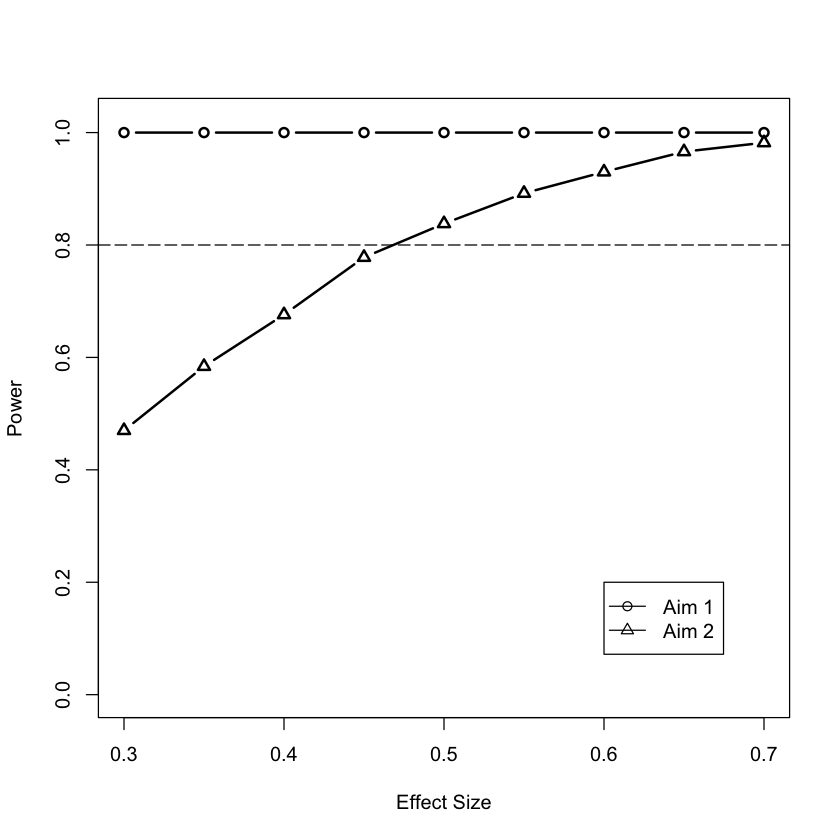

In [64]:
plot(powerSum[, c(1, 3)], type="b", ylab="Power", xlab="Effect Size", ylim=c(0, 1.02), lwd=2, pch=2)
lines(powerSum[, c(1,2)], type="b", lwd=2)
abline(h=0.8, lty=5)
legend(0.6, 0.2, legend=c("Aim 1", "Aim 2"), lty=c(1,1), pch=c(1,2))

In [65]:
save(powerSum, file = "power_summary.rdat")